In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import warnings

warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    log_loss,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import randint as sp_randint
from imblearn.over_sampling import SMOTE
import xgboost as xgb

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
)

In [3]:
df = pd.read_csv("res/UCI_Credit_Card.csv")
df.rename(columns={'PAY_0':'PAY_1','default.payment.next.month':'def_pay'},inplace=True) 
data = df
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,def_pay
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [4]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
df= data.drop(['def_pay','ID'],axis=1)
vif = pd.DataFrame()
vif['Features']= df.columns
vif['vif']= [variance_inflation_factor(df.values,i) for i in range(df.shape[1])]
vif

,Features,vif
0,LIMIT_BAL,4.037479
1,SEX,9.092210
2,EDUCATION,6.731119
3,MARRIAGE,6.265388
4,AGE,10.857679
5,PAY_1,1.918276
6,PAY_2,3.211217
7,PAY_3,3.727427
8,PAY_4,4.440120
9,PAY_5,4.985856


In [5]:
bill_tot = pd.DataFrame(
    data["BILL_AMT1"]
    + data["BILL_AMT2"]
    + data["BILL_AMT3"]
    + data["BILL_AMT4"]
    + data["BILL_AMT5"]
    + data["BILL_AMT6"],
    columns=["bill_tot"],
)
pay_tot = pd.DataFrame(
    data["PAY_1"]
    + data["PAY_2"]
    + data["PAY_3"]
    + data["PAY_4"]
    + data["PAY_5"]
    + data["PAY_6"],
    columns=["pay_tot"],
)

frames = [bill_tot, pay_tot, data["def_pay"]]
tot = pd.concat(frames, axis=1)

In [6]:
tot.head()

,bill_tot,pay_tot,def_pay
0,7704.0,-2,1
1,17077.0,3,1
2,101653.0,0,0
3,231334.0,0,0
4,109339.0,-2,0


In [7]:
tot.drop('def_pay',axis=1,inplace=True)


In [8]:
data1 = pd.concat([data,tot],axis = 1)

In [9]:
data1.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,def_pay,bill_tot,pay_tot
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1,7704.0,-2
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,17077.0,3
2,3,90000.0,2,2,2,34,0,0,0,0,...,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,101653.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,231334.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,109339.0,-2


In [10]:
df = pd.concat([bill_tot, df], axis=1)
df1 = df.drop(
    ["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"], axis=1
)

In [11]:
df1.head()

,bill_tot,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,7704.0,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,0.0,689.0,0.0,0.0,0.0,0.0
1,17077.0,120000.0,2,2,2,26,-1,2,0,0,0,2,0.0,1000.0,1000.0,1000.0,0.0,2000.0
2,101653.0,90000.0,2,2,2,34,0,0,0,0,0,0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
3,231334.0,50000.0,2,2,1,37,0,0,0,0,0,0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
4,109339.0,50000.0,1,2,1,57,-1,0,-1,0,0,0,2000.0,36681.0,10000.0,9000.0,689.0,679.0


In [12]:
vif = pd.DataFrame()
vif['Features']= df1.columns
vif['vif']= [variance_inflation_factor(df1.values,i) for i in range(df1.shape[1])]
vif

,Features,vif
0,bill_tot,2.195200
1,LIMIT_BAL,4.021099
2,SEX,9.076043
3,EDUCATION,6.710872
4,MARRIAGE,6.262482
5,AGE,10.857405
6,PAY_1,1.917353
7,PAY_2,3.187792
8,PAY_3,3.706226
9,PAY_4,4.427837


In [13]:
data2 = df1.copy()


In [14]:
age = [20, 27, 32, 37, 42, 48, 58, 64, 80]
lab = [8, 7, 6, 5, 4, 3, 2, 1]
data2["AGE"] = pd.cut(data2["AGE"], bins=age, labels=lab)

In [15]:
data2 = pd.concat([data2, data["def_pay"]], axis=1)
data2

,bill_tot,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,def_pay
0,7704.0,20000.0,2,2,1,8,2,2,-1,-1,-2,-2,0.0,689.0,0.0,0.0,0.0,0.0,1
1,17077.0,120000.0,2,2,2,8,-1,2,0,0,0,2,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,101653.0,90000.0,2,2,2,6,0,0,0,0,0,0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,231334.0,50000.0,2,2,1,6,0,0,0,0,0,0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,109339.0,50000.0,1,2,1,3,-1,0,-1,0,0,0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,725349.0,220000.0,1,3,1,5,0,0,0,0,0,0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,21182.0,150000.0,1,3,2,4,-1,-1,-1,-1,0,0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,70496.0,30000.0,1,2,2,6,4,3,2,-1,0,0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,266611.0,80000.0,1,3,1,5,1,-1,0,0,0,-1,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


<Figure size 1200x600 with 0 Axes>

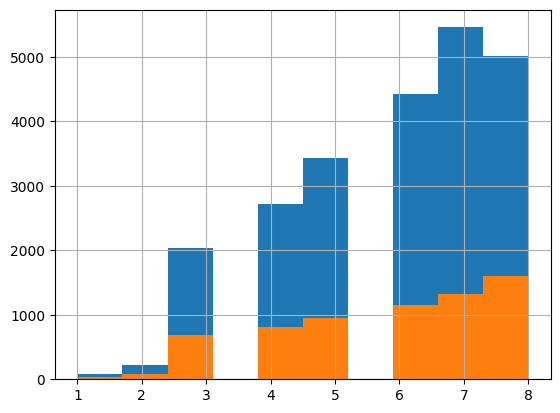

<Figure size 1200x600 with 0 Axes>

In [16]:
data2.groupby('def_pay')['AGE'].hist()
plt.figure(figsize=(12,6))

In [17]:
from sklearn.preprocessing import StandardScaler

x = data2.drop(["def_pay"], axis=1)
y = data2["def_pay"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=1
)
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [18]:
def res(y_test_valid, y_train_valid):
    cm_log = confusion_matrix(y_test, y_test_valid)
    ConfusionMatrixDisplay(cm_log).plot()
    
    print(f"f1_score = {f1_score(y_test, y_test_valid)}")
    
    print(classification_report(y_test, y_test_valid))
    
    print("train_accuracy:", accuracy_score(y_train, y_train_valid))
    print("test_accuracy:", accuracy_score(y_test, y_test_valid))

f1_score = 0.33448275862068966
              precision    recall  f1-score   support

           0       0.81      0.98      0.89      4663
           1       0.72      0.22      0.33      1337

    accuracy                           0.81      6000
   macro avg       0.77      0.60      0.61      6000
weighted avg       0.79      0.81      0.76      6000

train_accuracy: 0.8108333333333333
test_accuracy: 0.807


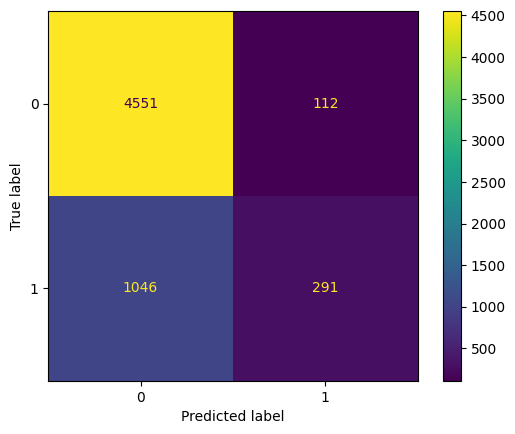

In [19]:
log_model = LogisticRegression()
log_model.fit(x_train, y_train)
y_pred_log = log_model.predict(x_test)
y_pred_train = log_model.predict(x_train)
res(y_pred_log, y_pred_train)

f1_score = 0.49612403100775193
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      4663
           1       0.64      0.41      0.50      1337

    accuracy                           0.82      6000
   macro avg       0.74      0.67      0.69      6000
weighted avg       0.80      0.82      0.80      6000

train_accuracy: 0.81375
test_accuracy: 0.8158333333333333


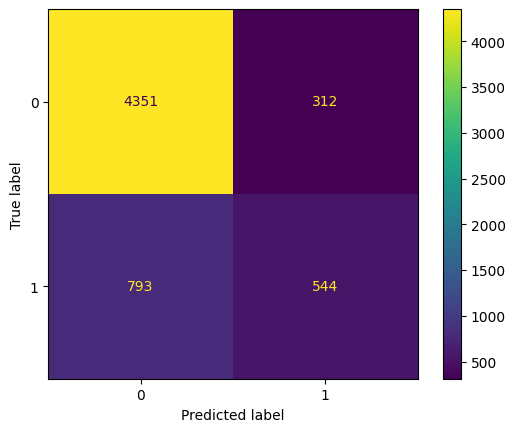

In [20]:
# With thresholding
threshold = 0.36
y_log_prob = log_model.predict_proba(x_test)
y_train_log_prob = log_model.predict_proba(x_train)
y_log_prob = y_log_prob[:, 1]

y_train_log_prob = y_train_log_prob[:, 1]
y_pred_log_prob = np.where(y_log_prob > threshold, 1, 0)
y_pred_log_prob_train = np.where(y_train_log_prob > threshold, 1, 0)

res(y_pred_log_prob, y_pred_log_prob_train)

f1_score = 0.3827785817655572
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      4663
           1       0.37      0.40      0.38      1337

    accuracy                           0.72      6000
   macro avg       0.60      0.60      0.60      6000
weighted avg       0.72      0.72      0.72      6000

train_accuracy: 0.9977083333333333
test_accuracy: 0.7156666666666667


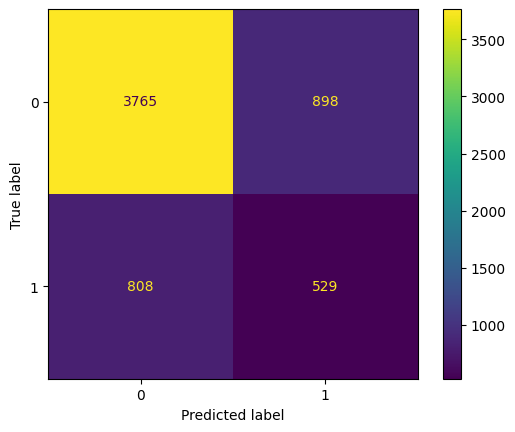

In [21]:
dec_model = DecisionTreeClassifier()
dec_model.fit(x_train, y_train)
y_pred_dec = dec_model.predict(x_test)
y_pred_dec_train = dec_model.predict(x_train)
res(y_pred_dec, y_pred_dec_train)

In [22]:
# rf_model = RandomForestClassifier(random_state=1)

# parameters = {'n_estimators':[60,70,80],'max_depth':[5,6],'min_samples_split':[3,4],
#               'min_samples_leaf':[4,6]}
# clf = GridSearchCV(rf_model, parameters,cv=10)
# clf.fit(x_train,y_train)
# clf.best_params_
#     # {'max_depth': 5,
#     #  'min_samples_leaf': 4,
#     #  'min_samples_split': 3,
#     #  'n_estimators': 70}

f1_score = 0.45271629778672035
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      4663
           1       0.69      0.34      0.45      1337

    accuracy                           0.82      6000
   macro avg       0.76      0.65      0.67      6000
weighted avg       0.80      0.82      0.79      6000

train_accuracy: 0.8244166666666667
test_accuracy: 0.8186666666666667


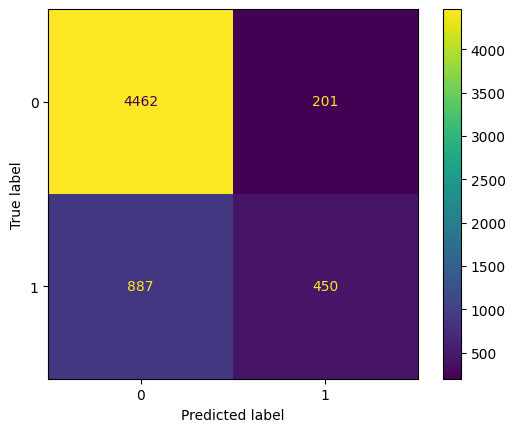

In [23]:
rf_model = RandomForestClassifier(
    n_estimators=70, max_depth=5, min_samples_leaf=4, min_samples_split=3
)
rf_model.fit(x_train, y_train)
y_pred_rf = rf_model.predict(x_test)
y_pred_rf_train = rf_model.predict(x_train)
res(y_pred_rf, y_pred_rf_train)

f1_score = 0.4596153846153846
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4663
           1       0.64      0.36      0.46      1337

    accuracy                           0.81      6000
   macro avg       0.74      0.65      0.67      6000
weighted avg       0.79      0.81      0.79      6000

train_accuracy: 0.8813333333333333
test_accuracy: 0.8126666666666666


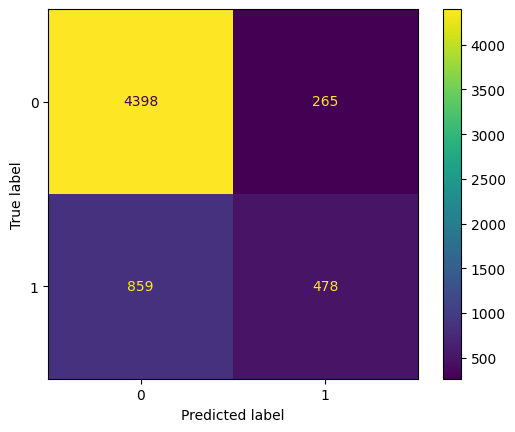

In [24]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(x_train, y_train)
xgb_y_predict = xgb_model.predict(x_test)
xgb_y_predict_train = xgb_model.predict(x_train)
res(xgb_y_predict, xgb_y_predict_train)

In [34]:
import catboost
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=1000, learning_rate=0.07, depth=10, verbose=200)

# Train the model
model.fit(x_train, y_train)

# Make predictions
y_pred = model.predict(x_test)


0:	learn: 0.6549728	total: 12.4ms	remaining: 12.4s
200:	learn: 0.3069876	total: 6.47s	remaining: 25.7s
400:	learn: 0.2328643	total: 13.7s	remaining: 20.5s
600:	learn: 0.1792406	total: 20.6s	remaining: 13.6s
800:	learn: 0.1409254	total: 27.7s	remaining: 6.87s
999:	learn: 0.1159297	total: 37s	remaining: 0us


f1_score = 0.4389294403892944
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      4663
           1       0.63      0.34      0.44      1337

    accuracy                           0.81      6000
   macro avg       0.73      0.64      0.66      6000
weighted avg       0.79      0.81      0.78      6000

train_accuracy: 1.0
test_accuracy: 0.8078333333333333


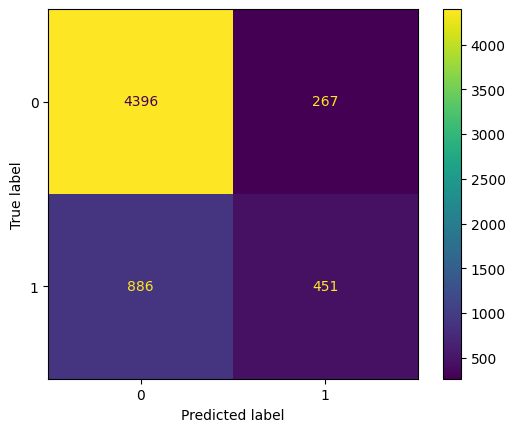

In [35]:
res(y_pred, y_train)
